In [2]:
%pylab inline

from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.modeling.models import Sersic1D

# AstroML
from astroML.plotting import hist

# Matplotlib related
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

# Personal
import hscUtils as hUtil
import galSBP
import coaddCutoutGalfitSimple as gSimple 

import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [61]:
# Absolute magnitude of sun in HSC filters

# Actuall borrowed from DES filters
# Values from magsun.data in FSPS
amag_sun_des_g = 5.08
amag_sun_des_r = 4.62
amag_sun_des_i = 4.52
amag_sun_des_z = 4.52
amag_sun_des_y = 4.51

# Based on http://www.baryons.org/ezgal/filters.php
amag_sun_ukiss_y = 4.515

# Extinction correction factor for HSC 
## A\_lambda = Coeff * E(B-V) 

a_hsc_g = 3.233
a_hsc_r = 2.291 
a_hsc_i = 1.635
a_hsc_z = 1.261
a_hsc_y = 1.076

# 
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

RSMA_COMMON = np.arange(0.4, 4.2, 0.02)

### Fancy one 
# definitions for the axes
left, width    = 0.12, 0.69
right          = left + width 
bottom, height = 0.12, 0.86
bottom_h = left_h = left + width + 0.02

recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.18, height]

SBP1 = [0.125, 0.066, 0.869, 0.320]
SBP2 = [0.125, 0.386, 0.869, 0.585]

EC1 = [0.135, 0.066, 0.862, 0.30]
EC2 = [0.135, 0.366, 0.862, 0.30]
EC3 = [0.135, 0.666, 0.862, 0.30]

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"

RED0 = "#f4a582"
RED1 = "#ca0020"

PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'

BROWN0 = '#bf812d'
BROWN1 = '#543005'

GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

In [3]:
def doubleSchechter(logm, logm0=10.91, 
                    logphi1=-2.97, logphi2=-2.79, 
                    alpha1=-0.46, alpha2=-1.58):
    
    phi1 = (10.0 ** logphi1)
    phi2 = (10.0 ** logphi2)
    dlogm = (logm - logm0)
    
    term1 = np.log(10.0) * np.exp(-1.0 * (10.0 ** dlogm))
    term2 = phi1 * (10.0 ** ((alpha1 + 1.0) * dlogm))
    term3 = phi2 * (10.0 ** ((alpha2 + 1.0) * dlogm))
    
    return term1 * (term2 + term3)

In [16]:
mfG14 = Table.read('smf_Genel_14.txt', format='ascii')

mfM13 = Table.read('smf_Moustakas_13.txt', format='ascii')

mfB13 = Table.read('smf_Bernardi_13_serExp.txt', format='ascii')

mfD15 = Table.read('smf_dSouza_15.txt', format='ascii')

massArr = np.arange(7.0, 13.0, 0.1)

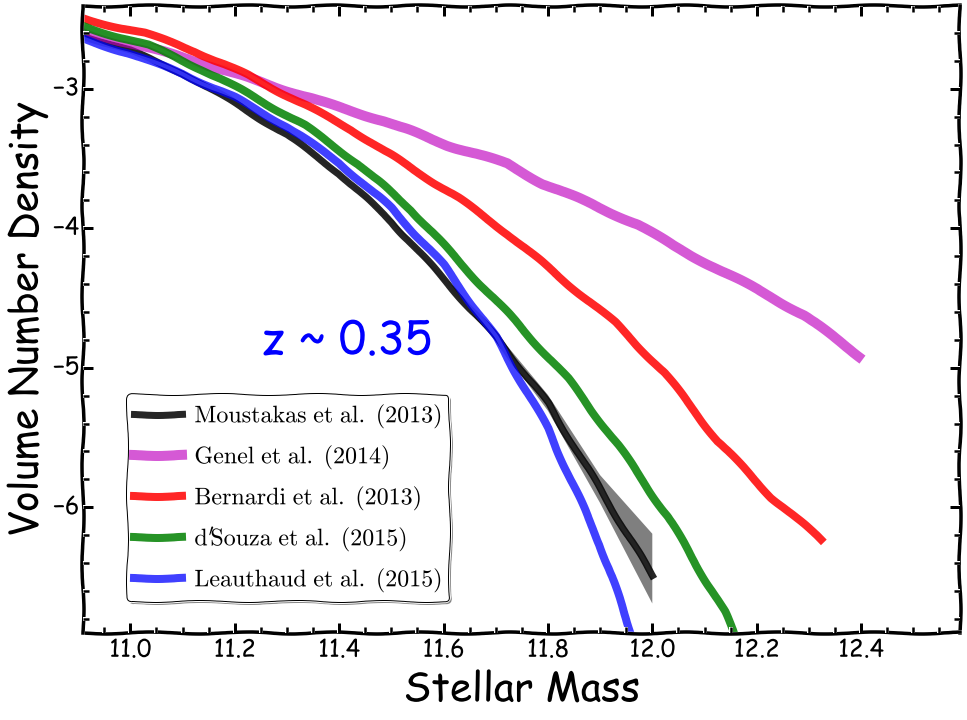

In [39]:
with plt.xkcd():
    
    fig = plt.figure(figsize=(14, 10))
    rec = [0.12, 0.12, 0.87, 0.87]
    ax1 = plt.axes(rec)

    hTerm1 = (2.0 * np.log10(0.72))
    hTerm2 = (3.0 * np.log10(0.72))

    
    # Moustakas+2013 
    ax1.fill_between(mfM13['logM'], (mfM13['logPhi'] + mfM13['lower']), 
                     (mfM13['logPhi'] + mfM13['upper']), edgecolor='none',
                     facecolor='k', alpha=0.5)
    ax1.plot(mfM13['logM'], mfM13['logPhi'], linestyle='-', linewidth=7.0, 
             alpha=0.85, c='k', label='$\mathrm{Moustakas\ et\ al.\ (2013)}$')

    # Genel+2014 
    ax1.plot(mfG14['x'] - 0.05, mfG14['y'] + 0.1, linestyle='-', 
             linewidth=10.0, alpha=0.65, 
             c='m', label='$\mathrm{Genel\ et\ al.\ (2014)}$')
    
    # Bernardi+2013; SerExp
    ax1.plot(mfB13['col1'] - hTerm1, mfB13['col2'] + hTerm2, linestyle='-', 
             linewidth=8.0, alpha=0.85, c='r', label='$\mathrm{Bernardi\ et\ al.\ (2013)}$')

    # d'Souza+2015; 
    ax1.plot(mfD15['col1'] - hTerm1, mfD15['col2'] + hTerm2, linestyle='-', 
             linewidth=8.0, alpha=0.85, c='g', label='$\mathrm{d\'Souza\ et\ al.\ (2015)}$')

    # Leauthaud+2015
    ax1.plot(massArr, np.log10(doubleSchechter(massArr)), c='b',
             linestyle='-', linewidth=8.0, alpha=0.75, 
             label='$\mathrm{Leauthaud\ et\ al.\ (2015)}$')
    
    # Axes setup
    #  Minor Ticks on 
    ax1.minorticks_on()

    #  Axes Thickness
    for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(3.5)
    #  Tick Label Size 
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    
    #  Tick Length and Width
    ax1.tick_params('both', length=10, width=3.0, which='major')
    ax1.tick_params('both', length=6, width=2.5, which='minor')
    
    # Legend 
    ax1.legend(loc=(0.05, 0.05), shadow=True, fancybox=True, 
               numpoints=1, fontsize=24, scatterpoints=1, 
               markerscale=1.2, borderpad=0.3, handletextpad=0.50)

    ax1.set_xlim(10.91, 12.59)
    ax1.set_ylim(-6.9, -2.41)
    
    #ax1.text(11.6, -2.8, 'More AGN Feedback?', color='k', fontsize=40)
    #ax1.text(12.3, -5.8, '?!', color='k', fontsize=65)
    #ax1.text(12.15, -6.6, 'Wait...', color='k', fontsize=45)
    ax1.text(11.25, -4.9, 'z ~ 0.35', color='b', fontsize=45)
    # Label
    ax1.set_xlabel('Stellar Mass', size=40)
    ax1.set_ylabel('Volume Number Density', size=39)

fig.savefig('../figure/smf_cartoon_6.png', dpi=200)

plt.show()

# 1-D profiles

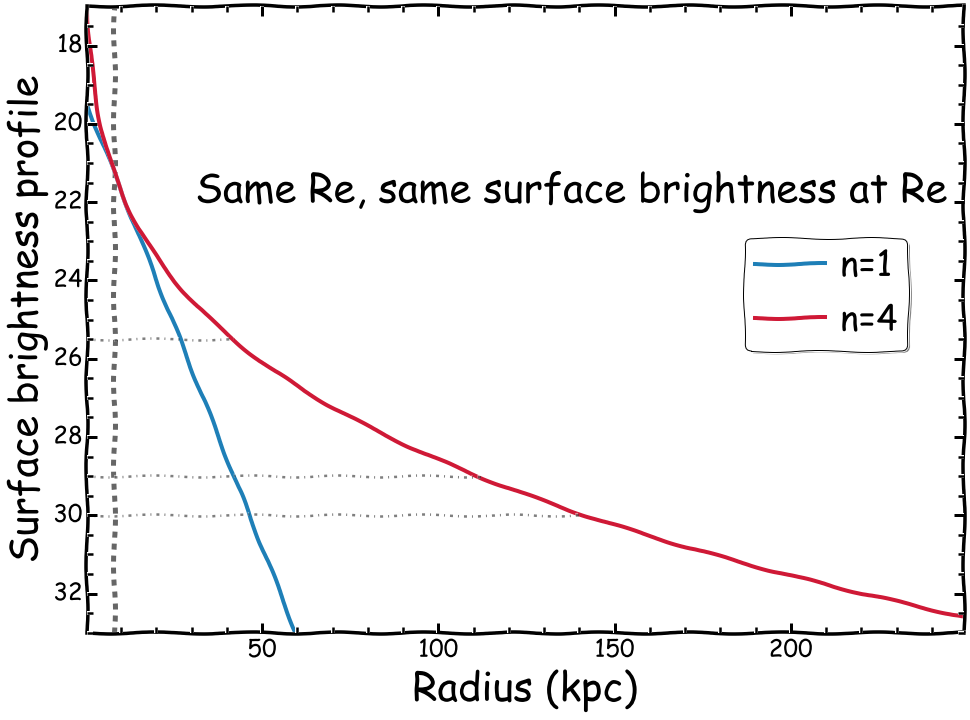

In [75]:
expShow = Sersic1D(amplitude=200.0, r_eff=8.0, n=1.0)
devShow = Sersic1D(amplitude=200.0, r_eff=8.0, n=4.0)

rKpc = np.arange(0, 4.5, 0.01)
kpc = (rKpc ** 4.0)

with plt.xkcd():
    
    fig = plt.figure(figsize=(14, 10))
    rec = [0.12, 0.12, 0.87, 0.87]
    ax1 = plt.axes(rec)

    ax1.axvline(8.0, linewidth=5.0, linestyle='--', c='k', alpha=0.6)
    
    ax1.plot(kpc, 27.0 - 2.5 * np.log10(expShow(kpc)), color=BLUE1,
             linewidth=4.0, alpha=0.9, label='n=1')
    ax1.plot(kpc, 27.0 - 2.5 * np.log10(devShow(kpc)), color=RED1, 
             linewidth=4.0, alpha=0.9, label='n=4')
    
    # Axes setup
    #  Minor Ticks on 
    ax1.minorticks_on()

    #  Axes Thickness
    for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(3.5)
    #  Tick Label Size 
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    
    #  Tick Length and Width
    ax1.tick_params('both', length=10, width=3.0, which='major')
    ax1.tick_params('both', length=6, width=2.5, which='minor')

    ax1.legend(loc=(0.75, 0.45), shadow=True, fancybox=True, 
               numpoints=1, fontsize=35, scatterpoints=1, 
               markerscale=1.2, borderpad=0.3, handletextpad=0.44)

    ax1.set_xlim(0.2, 249.0)
    ax1.set_ylim(33.0, 17.0)

    # Label
    ax1.set_xlabel('Radius (kpc)', size=40)
    ax1.set_ylabel('Surface brightness profile', size=39)

    ax1.text(31.0, 22.0, 'Same Re, same surface brightness at Re', fontsize=40)
    
    ax1.plot([0.0, 42.0], [25.5, 25.5], linestyle='-.', linewidth=2.5, c='k', alpha=0.5)
    ax1.plot([0.0, 112.0], [29.0, 29.0], linestyle='-.', linewidth=2.5, c='k', alpha=0.5)
    ax1.plot([0.0, 140.0], [30.0, 30.0], linestyle='-.', linewidth=2.5, c='k', alpha=0.5)
    
plt.show()

fig.savefig('../figure/sbp_cartoon_1.png', dpi=300)

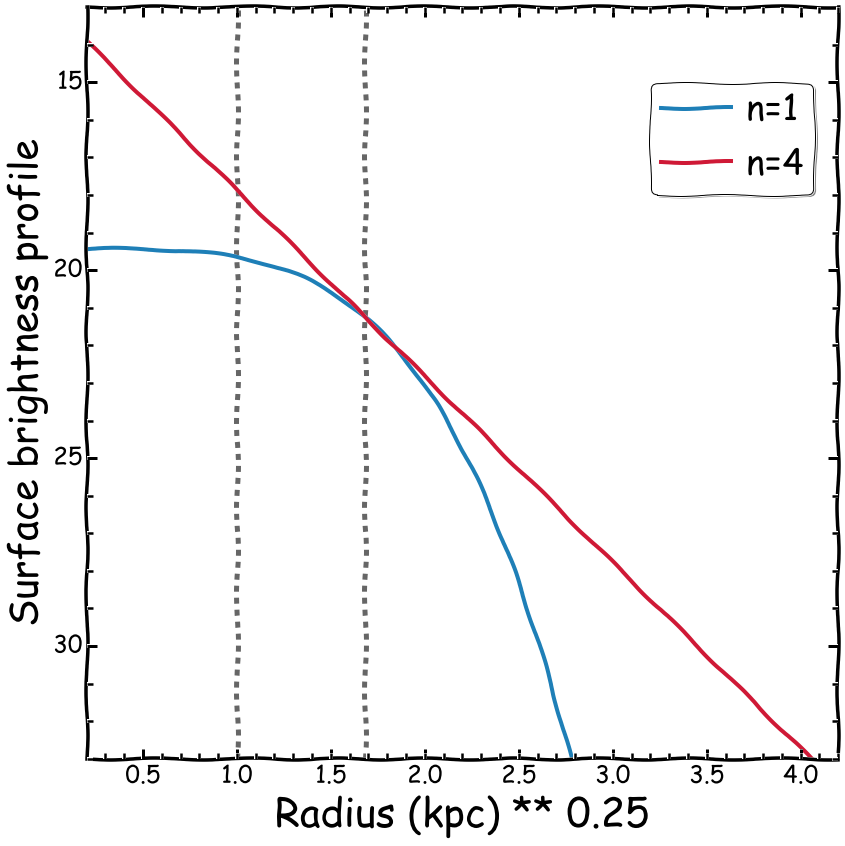

In [79]:
expShow = Sersic1D(amplitude=200.0, r_eff=8.0, n=1.0)
devShow = Sersic1D(amplitude=200.0, r_eff=8.0, n=4.0)

rKpc = np.arange(0, 4.5, 0.01)
kpc = (rKpc ** 4.0)

with plt.xkcd():
    
    fig = plt.figure(figsize=(12, 12))
    rec = [0.12, 0.12, 0.87, 0.87]
    ax1 = plt.axes(rec)

    ax1.axvline(8.0 ** 0.25, linewidth=5.0, linestyle='--', c='k', alpha=0.6)
    
    ax1.axvline(1.0 ** 0.25, linewidth=5.0, linestyle='--', c='k', alpha=0.6)

    
    ax1.plot(rKpc, 27.0 - 2.5 * np.log10(expShow(kpc)), color=BLUE1,
             linewidth=4.0, alpha=0.9, label='n=1')
    ax1.plot(rKpc, 27.0 - 2.5 * np.log10(devShow(kpc)), color=RED1, 
             linewidth=4.0, alpha=0.9, label='n=4')
    
    # Axes setup
    #  Minor Ticks on 
    ax1.minorticks_on()

    #  Axes Thickness
    for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(3.5)
    #  Tick Label Size 
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    
    #  Tick Length and Width
    ax1.tick_params('both', length=10, width=3.0, which='major')
    ax1.tick_params('both', length=6, width=2.5, which='minor')

    ax1.legend(loc=(0.75, 0.75), shadow=True, fancybox=True, 
               numpoints=1, fontsize=35, scatterpoints=1, 
               markerscale=1.2, borderpad=0.3, handletextpad=0.44)

    ax1.set_xlim(0.2, 4.2)
    ax1.set_ylim(33.0, 13.0)

    # Label
    ax1.set_xlabel('Radius (kpc) ** 0.25', size=40)
    ax1.set_ylabel('Surface brightness profile', size=39)
    
plt.show()

fig.savefig('../figure/sbp_cartoon_2.png', dpi=300)